In [1]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import math
import numpy as np
from typing import Tuple

In [6]:
arr1 = np.random.rand(128,128) + 1j*np.random.rand(128,128)
arr2 = np.random.rand(128,128) + 1j*np.random.rand(128,128)

In [7]:
ten1 = torch.from_numpy(arr1)
ten2 = torch.from_numpy(arr2)


In [8]:
torch.zeros((128,128),dtype=torch.cfloat)

tensor([[0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j]])

In [16]:
(ten2*ten1).abs()

tensor([[0.2118, 0.7386, 1.0089,  ..., 0.2318, 0.8225, 0.4918],
        [0.7821, 1.2116, 0.5172,  ..., 0.6790, 0.2371, 0.3081],
        [0.7680, 0.6770, 0.1022,  ..., 1.1667, 0.3258, 0.9719],
        ...,
        [0.2577, 0.2949, 0.4128,  ..., 0.3187, 0.5773, 1.1858],
        [0.9380, 0.0839, 0.7225,  ..., 0.8312, 0.9727, 0.6477],
        [0.9012, 0.7513, 0.5390,  ..., 0.2594, 0.4395, 0.3805]],
       dtype=torch.float64)

In [46]:
matrix_size = 128
x_co = torch.Tensor([x-matrix_size//2 for x in range(matrix_size)]).unsqueeze(0).repeat(matrix_size,1)/(matrix_size//2)
y_co = torch.Tensor([y-matrix_size//2 for y in range(matrix_size)]).unsqueeze(-1).repeat(1,matrix_size)/(matrix_size//2)
y_co

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-0.9844, -0.9844, -0.9844,  ..., -0.9844, -0.9844, -0.9844],
        [-0.9688, -0.9688, -0.9688,  ..., -0.9688, -0.9688, -0.9688],
        ...,
        [ 0.9531,  0.9531,  0.9531,  ...,  0.9531,  0.9531,  0.9531],
        [ 0.9688,  0.9688,  0.9688,  ...,  0.9688,  0.9688,  0.9688],
        [ 0.9844,  0.9844,  0.9844,  ...,  0.9844,  0.9844,  0.9844]])

In [12]:
def generate_birdcage_sensitivities(matrix_size: int = 256, number_of_coils: int = 8, relative_radius: float = 1.5, rotation: float = 0.0, normalize: bool = True) -> torch.Tensor:
    """ 
    Generates a PyTorch complex tensor with birdcage coil sensitivites.

    :param matrix_size: size of imaging matrix in pixels (default ``256``)
    :param number_of_coils: Number of simulated coils (default ``8``)
    :param relative_radius: Relative radius of birdcage (default ``1.5``)
    :return torch.Tensor [Nc, Ny, Nx]

    This function is heavily inspired by:

        1. The mri_birdcage.m Matlab script in Jeff Fessler's IRT package: http://web.eecs.umich.edu/~fessler/code/
        2. generate_birdcage_sensitivities function from ISMRMRD Python tools (https://github.com/ismrmrd/ismrmrd-python-tools)
    """

    out = torch.zeros((number_of_coils,matrix_size,matrix_size), dtype=torch.cfloat)
    x_coord = torch.Tensor([x-matrix_size//2 for x in range(matrix_size)]).unsqueeze(0).repeat(matrix_size,1)/(matrix_size//2)
    y_coord = torch.Tensor([y-matrix_size//2 for y in range(matrix_size)]).unsqueeze(-1).repeat(1,matrix_size)/(matrix_size//2)

    for c in range(0,number_of_coils):
        coilx = relative_radius*math.cos(c*(2*math.pi/number_of_coils)+rotation)
        coily = relative_radius*math.sin(c*(2*math.pi/number_of_coils)+rotation)
        coil_phase = -c*(2*math.pi/number_of_coils)
        y_co = y_coord - coily
        x_co = x_coord - coilx
        rr = torch.sqrt(x_co**2 + y_co**2)
        phi = torch.atan2(x_co,-y_co) + coil_phase
        out[c,...] = 1/rr * torch.exp(1j*phi)
        
    if normalize:
         rss = torch.sqrt(torch.sum(torch.abs(out) ** 2, 0))
         out = out / rss.unsqueeze(0)

    return out

In [13]:
coils = generate_birdcage_sensitivities(128)

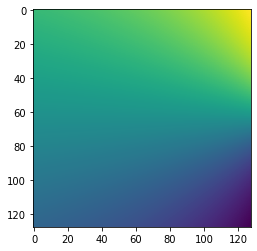

In [14]:
plt.imshow(coils[0,...].angle())

In [73]:
def generate_birdcage_sensitivities_old(matrix_size = 256, number_of_coils = 8, relative_radius = 1.5, rotation = 0.0, normalize=True) -> np.ndarray:
    """ 
    Generates birdcage coil sensitivites.

    :param matrix_size: size of imaging matrix in pixels (default ``256``)
    :param number_of_coils: Number of simulated coils (default ``8``)
    :param relative_radius: Relative radius of birdcage (default ``1.5``)

    This function is heavily inspired by the mri_birdcage.m Matlab script in
    Jeff Fessler's IRT package: http://web.eecs.umich.edu/~fessler/code/
    """

    out = np.zeros((number_of_coils,matrix_size,matrix_size),dtype=np.complex64)
    for c in range(0,number_of_coils):
        coilx = relative_radius*np.cos(c*(2*np.pi/number_of_coils)+rotation)
        coily = relative_radius*np.sin(c*(2*np.pi/number_of_coils)+rotation)
        coil_phase = -c*(2*np.pi/number_of_coils)

        for y in range(0,matrix_size):
            y_co = float(y-matrix_size/2)/float(matrix_size/2)-coily
            for x in range(0,matrix_size):
                x_co = float(x-matrix_size/2)/float(matrix_size/2)-coilx
                rr = np.sqrt(x_co**2+y_co**2)
                phi = np.arctan2(x_co, -y_co) + coil_phase
                out[c,y,x] =  (1/rr) * np.exp(1j*phi)

    if normalize:
         rss = np.squeeze(np.sqrt(np.sum(abs(out) ** 2, 0)))
         out = out / np.tile(rss,(number_of_coils,1,1))

    return out

In [16]:
coils1 = generate_birdcage_sensitivities(128,8,rotation=math.pi/2).numpy()
# coils2 = generate_birdcage_sensitivities_old(128,8,rotation=math.pi/2)


In [75]:
np.max(np.abs(coils1-coils2))

4.80548e-07

In [27]:
def ifft(data: torch.Tensor, dim: Tuple[int, ...] = None) -> torch.Tensor:
    """ 
    Computes the inverse Fourier transform from (k-space to image)

    :param data: k-space data as complex torch.Tensor
    :param dim: dimensions to transform
    :returns: transformed data
    """

    if not dim:
        dim = tuple([x in range(data.ndim)])
        # Since torch can only do up to 3 dimensions, we will pick the last 3
        if len(dim) > 3:
            dim = dim[-3:]
    
    # Torch ffts only support 1, 2, or 3 dimensions
    assert len(dim) <= 3 and len(dim) >= 1

    # ifftshift
    shifts = [(data.shape[x] + 1) // 2 for x in dim]
    data = torch.roll(data, shifts, dim)

    # Permute, ifft, unpermute
    permute_dim,unpermute_dim = get_fft_permute_dims(data.ndim, dim)
    data = data.permute(permute_dim)
    data = torch.view_as_complex(torch.ifft(torch.view_as_real(data), len(dim)))
    data = data.permute(unpermute_dim)

    # fftshift
    shifts = [(data.shape[x]) // 2 for x in dim]
    data = torch.roll(data, shifts, dim)

    # Scaling
    data *= torch.sqrt(torch.prod(torch.Tensor([data.shape[d] for d in dim])))

    return data


In [28]:
coils1trf = ifft(coils,(-2,-1))

In [81]:
coils = generate_birdcage_sensitivities(128)

In [24]:
dim=(-2,-1)
torch.sqrt(torch.prod(torch.Tensor([coils.shape[d] for d in dim])))
#scale = torch.sqrt(torch.Tensor([1.0*data.shape[-2]*data.shape[-3]]).to(data.device))


tensor(128.)

In [84]:
dim

(0, 1, 2)

In [87]:
shifts = [coils.shape[x] // 2 for x in dim]

In [88]:
shifts

[4, 64, 64]

In [90]:
tmptuple = (2,3,4,5,6)
tmptuple[-3:]

(4, 5, 6)

In [94]:
permuted_dims = (3,4,2,1,0)
unpermuted_dims = list(permuted_dims)
for i, d in enumerate(permuted_dims):
    unpermuted_dims[d] = i
unpermuted_dims

[4, 3, 2, 0, 1]

In [99]:
dim = (-2,2)
dd = [(d+ndim)%ndim for d in dim]
ndim = 5
permute_dims = []
for d in range(ndim):
    if d not in dd:
        permute_dims.append(d)
for d in dd:
    permute_dims.append((d+ndim)%ndim)
permute_dims

[0, 1, 4, 3, 2]

In [7]:
def get_fft_permute_dims(ndim: int, transform_dim: Tuple[int,...]) -> Tuple[Tuple[int,...],Tuple[int,...]]:
    """
    Helper function for determiming permute dimensions for FFT/IFFT.
    
    Returns permutation orders needed for moving the transform dimensions `transform_dim` to the highest dimensions and back.

    :param ndim: total number of dimensions
    :param transform_dim: dimensions to transform
    :return permute_dim,unpermute_dim: tuples needed to permute and unpermute

    """
    dd = [d%ndim for d in transform_dim]
    permute_dims = []
    for d in range(ndim):
        if d not in dd:
            permute_dims.append(d)
    for d in dd:
        permute_dims.append(d%ndim)

    permute_dims = tuple(permute_dims)

    unpermute_dims = [0 for _ in range(ndim)]
    for i, d in enumerate(permute_dims):
        unpermute_dims[d] = i
    unpermute_dims = tuple(unpermute_dims)

    return permute_dims,unpermute_dims


In [10]:
get_fft_permute_dims(5, (3,4))

((0, 1, 2, 3, 4), (0, 1, 2, 3, 4))

In [119]:
0%5

0